# Data Pre-processing
- Image Processing
        - Train-dev-test split
        - Resize Images
        - Data Augmentation
        
- Generate HDF5 Files    
        - Convert to numpy data
        - Generate H5 Data
        - Check H5 Data

## Import Libraries

In [1]:
from os import listdir
from PIL import Image
from imageio import imread
from random import shuffle, seed
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


## Variable Constants

In [2]:
# PATH VARIABLES
# Depending on how many classes, will populate the respective lists
SUB_PATH = "./datasets/"
_RAW_PATH = ["y0_raw","y1_raw"]
_TRAIN_PATH = ["y0_train","y1_train"]
_TEST_PATH = ["y0_test","y1_test"]
_DEV_PATH = ["y0_dev","y1_dev"]

# DECLARATION OF Y0 AND Y1
Y0 = "cat"
Y1 = "dog"

# FINAL PATH VARIABLES
RAW_PATH = [SUB_PATH + x for x in _RAW_PATH]
TRAIN_PATH = [SUB_PATH + x + "/" for x in _TRAIN_PATH]
TEST_PATH = [SUB_PATH + x + "/" for x in _TEST_PATH]
DEV_PATH = [SUB_PATH + x + "/" for x in _DEV_PATH]

# IMAGE SIZE CONSTANT
# A value that the original image is to be resized
NUM_PX = 128
NUM_PY = 128

# SPLIT FLAG
# == True if data hasn't been splitted into train, dev, test set
# == False if data has already been splitted into train, dev, test set 
# (False requires creation of 6 folders beforehand and place raw pictures into the respective folders
# [y0_train, y0_dev, y0_test, y1_train, y1_dev, y1_test]
SPLIT_FLAG = False

# TRAIN SIZE AND DEV SIZE CONSTANT
# Proportion of train-dev-test data size
# None if data has already been splitted into train-dev-test
TRAIN_SIZE = None
DEV_SIZE = None

# DATA AUGMENTATION CONSTANT
# Total number of images in the end, including the base image
# 1 if no augmentation
NO_OF_IMAGES = 1

# Image Processing

In [3]:
def resize_image(raw_path, flist, input_path, des, split, num_px=NUM_PX, num_py=NUM_PY):
    imgs = flist 
    imgs.sort()
    
    if(split):
        for i in imgs:
            image = Image.open(raw_path + '/' + i)
            new_image = image.resize((num_px, num_py))
            new_image.save(des + '/' + i)
            
    else:
        for i in imgs:
            image = Image.open(input_path + '/' + i)
            new_image = image.resize((num_px, num_py))
            new_image.save(des + '/' + i)

In [4]:
def data_augmentation(count, train_dir, des):
    datagen = ImageDataGenerator(rotation_range = 15, 
                     width_shift_range = 0.2, 
                     height_shift_range = 0.2,  
                     rescale=1./255, 
                     shear_range=0.2, 
                     zoom_range=0.2, 
                     horizontal_flip = True, 
                     fill_mode = 'nearest', 
                     data_format = 'channels_last', 
                     brightness_range=[0.5, 1.5])
    
    imgs = listdir(train_dir)
    
    for img in imgs:
        img = imread(train_dir+"/"+img)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        if(i == count):
            break
        else:
            for batch in datagen.flow (x, batch_size=1, save_to_dir = des , save_prefix ='', save_format='jpg'):
                i+=1
                if i>=count:
                    break   

In [5]:
def image_processing(train_size, dev_size, split, raw_path, train_dir, dev_dir, test_dir, count, aug_dir, seeds=230, seed_flag=False):
    # Get filepath of the images from the raw image folder
    imgs = listdir(raw_path)
    
    # Split the images into train, dev, test if the images are not splitted yet
    # split == True will shuffle the images then split it
    
    # If images are already splitted into the 3 sets, create 6 folders beforehand and place raw pictures into the respective folders
    # [y0_train, y0_dev, y0_test, y1_train, y1_dev, y1_test]
    # split == False will read the filenames of the respective directories

    if(split):
        imgs.sort()
        if(seed_flag):
            seed(seeds)
        # Get randomised image order for the split
        shuffle(imgs)

        # Get the breakpoint to split images into its respoective categories    
        train_dev_size = train_size + dev_size

        # Split begins
        _train_set = imgs[:int(train_size*len(imgs))]
        _dev_set = imgs[int(train_size*len(imgs)):int(train_dev_size*len(imgs))]
        _test_set = imgs[int(train_dev_size*len(imgs)):]
        print("Train-dev-test split DONE!")

        # Ensures proportion of images of the train and dev set stays below 1
        assert(train_dev_size <= 1)
        
    # Can set train_size and dev_size to None if data is already splitted  
    else:
        _train_set = listdir(train_dir)
        _dev_set = listdir(dev_dir)
        _test_set = listdir(test_dir)

    # Resize images to desired size
    resize_image(raw_path, _train_set, train_dir, train_dir, split)
    resize_image(raw_path, _dev_set, dev_dir, dev_dir, split)
    resize_image(raw_path, _test_set, test_dir, test_dir, split)
    print("Resize DONE!")
        
    # Data Augmentation
    data_augmentation(count, train_dir, aug_dir)
    print("Image Augmentation DONE!")

## Get Processed Images

In [6]:
for i in range(len(RAW_PATH)):
    image_processing(TRAIN_SIZE,DEV_SIZE,SPLIT_FLAG,RAW_PATH[i],TRAIN_PATH[i],DEV_PATH[i],TEST_PATH[i],NO_OF_IMAGES-1,TRAIN_PATH[i])

Resize DONE!
Image Augmentation DONE!
Resize DONE!
Image Augmentation DONE!


# Generate HDF5 Files

## Convert to Numpy Data

In [7]:
def generate_numpy_data(y0_train, y0_dev, y0_test, y1_train, y1_dev, y1_test, y0_label, y1_label, seeds=1):
    
    y0_train_img_list = listdir(y0_train)
    y0_dev_img_list = listdir(y0_dev)
    y0_test_img_list = listdir(y0_test)
    y1_train_img_list = listdir(y1_train)
    y1_dev_img_list = listdir(y1_dev)
    y1_test_img_list = listdir(y1_test)
    
    len_y0_train_img_list = len(y0_train_img_list)
    len_y0_dev_img_list = len(y0_dev_img_list)
    len_y0_test_img_list = len(y0_test_img_list)
    len_y1_train_img_list = len(y1_train_img_list)
    len_y1_dev_img_list = len(y1_dev_img_list)
    len_y1_test_img_list = len(y1_test_img_list)
    
    #holder for the pixel array
    _train_x_set = list()
    _dev_x_set = list()
    _test_x_set = list()   
    _train_y_set = list()
    _dev_y_set = list()
    _test_y_set = list()
    
    _train_list_classes_set = list()
    _dev_list_classes_set = list()
    _test_list_classes_set = list()
    
    for i in range(len_y0_train_img_list):
        fname = y0_train + y0_train_img_list[i]
        img = imread(fname)
        image = np.array(img)
        _train_x_set.append(image)
        _train_y_set.append(0)
        _train_list_classes_set.append(y0_label.encode())
        
    for i in range(len_y0_dev_img_list):
        fname = y0_dev + y0_dev_img_list[i]
        img = imread(fname)
        image = np.array(img)
        _dev_x_set.append(image)
        _dev_y_set.append(0)
        _dev_list_classes_set.append(y0_label.encode())
        
    for i in range(len_y0_test_img_list):
        fname = y0_test + y0_test_img_list[i]
        img = imread(fname)
        image = np.array(img)
        _test_x_set.append(image)
        _test_y_set.append(0)
        _test_list_classes_set.append(y0_label.encode())

    for i in range(len_y1_train_img_list):
        fname = y1_train + y1_train_img_list[i]
        img = imread(fname)
        image = np.array(img)
        _train_x_set.append(image)
        _train_y_set.append(1)
        _train_list_classes_set.append(y1_label.encode())
        
    for i in range(len_y1_dev_img_list):
        fname = y1_dev + y1_dev_img_list[i]
        img = imread(fname)
        image = np.array(img)
        _dev_x_set.append(image)
        _dev_y_set.append(1)
        _dev_list_classes_set.append(y1_label.encode())
        
    for i in range(len_y1_test_img_list):
        fname = y1_test + y1_test_img_list[i]
        img = imread(fname)
        image = np.array(img)
        _test_x_set.append(image)
        _test_y_set.append(1)
        _test_list_classes_set.append(y1_label.encode())
        
    assert(len(_train_x_set) == len(_train_y_set))
    assert(len(_dev_x_set) == len(_dev_y_set))
    assert(len(_test_x_set) == len(_test_y_set))
    
    # Shuffle the list for data consistency with fixed seed
    seed(seeds)
    shuffle(_train_x_set)
    seed(seeds)
    shuffle(_dev_x_set)
    seed(seeds)
    shuffle(_test_x_set)
    seed(seeds)
    shuffle(_train_y_set)
    seed(seeds)
    shuffle(_dev_y_set)
    seed(seeds)
    shuffle(_test_y_set)
    seed(seeds)
    shuffle(_train_list_classes_set)
    seed(seeds)
    shuffle(_dev_list_classes_set)
    seed(seeds)
    shuffle(_test_list_classes_set)
    
    # Convert to np array
    train_x_set = np.array(_train_x_set)
    train_y_set = np.array(_train_y_set).reshape(1,-1)
    dev_x_set = np.array(_dev_x_set)
    dev_y_set = np.array(_dev_y_set).reshape(1,-1)
    test_x_set = np.array(_test_x_set)
    test_y_set = np.array(_test_y_set).reshape(1,-1)
    train_list_classes_set = np.array(_train_list_classes_set).reshape(1,-1)
    dev_list_classes_set = np.array(_dev_list_classes_set).reshape(1,-1)
    test_list_classes_set = np.array( _test_list_classes_set).reshape(1,-1)
    
    # Initialise empty dictionary
    dataset = dict()
            
    dataset["train_x"] = train_x_set
    dataset["train_y"] = train_y_set
    dataset["dev_x"] = dev_x_set
    dataset["dev_y"] = dev_y_set
    dataset["test_x"] = test_x_set
    dataset["test_y"] = test_y_set
    dataset["train_list_classes"] = train_list_classes_set
    dataset["dev_list_classes"] = dev_list_classes_set
    dataset["test_list_classes"] = test_list_classes_set
    
    return dataset

In [8]:
dataset = generate_numpy_data(TRAIN_PATH[0],DEV_PATH[0],TEST_PATH[0],TRAIN_PATH[1],DEV_PATH[1],TEST_PATH[1],Y0,Y1)

## Check if data is loaded properly

In [9]:
def show_first_20(numpy_array,label_array,offset=0):
    plt.figure(figsize=(20,20))
    assert(len(numpy_array)==len(label_array))
    datalen = len(numpy_array)
    numOfIter = min(datalen,20)
    if numOfIter < 20:
        offset = 0
    numOfRow = numOfIter//5 
    if numOfIter%5 != 0:
        numOfRow += 1
        
    for i in range(numOfIter):
        plt.subplot(numOfRow,5,i+1)
        plt.imshow(numpy_array[i+offset])
        print(f'IMG {i+1} is labelled {label_array[i+offset]}')

IMG 1 is labelled 0
IMG 2 is labelled 0
IMG 3 is labelled 0
IMG 4 is labelled 1
IMG 5 is labelled 1
IMG 6 is labelled 0
IMG 7 is labelled 1
IMG 8 is labelled 0
IMG 9 is labelled 1
IMG 10 is labelled 1
IMG 11 is labelled 0
IMG 12 is labelled 0
IMG 13 is labelled 1
IMG 14 is labelled 1
IMG 15 is labelled 1
IMG 16 is labelled 0
IMG 17 is labelled 0
IMG 18 is labelled 1
IMG 19 is labelled 1
IMG 20 is labelled 1


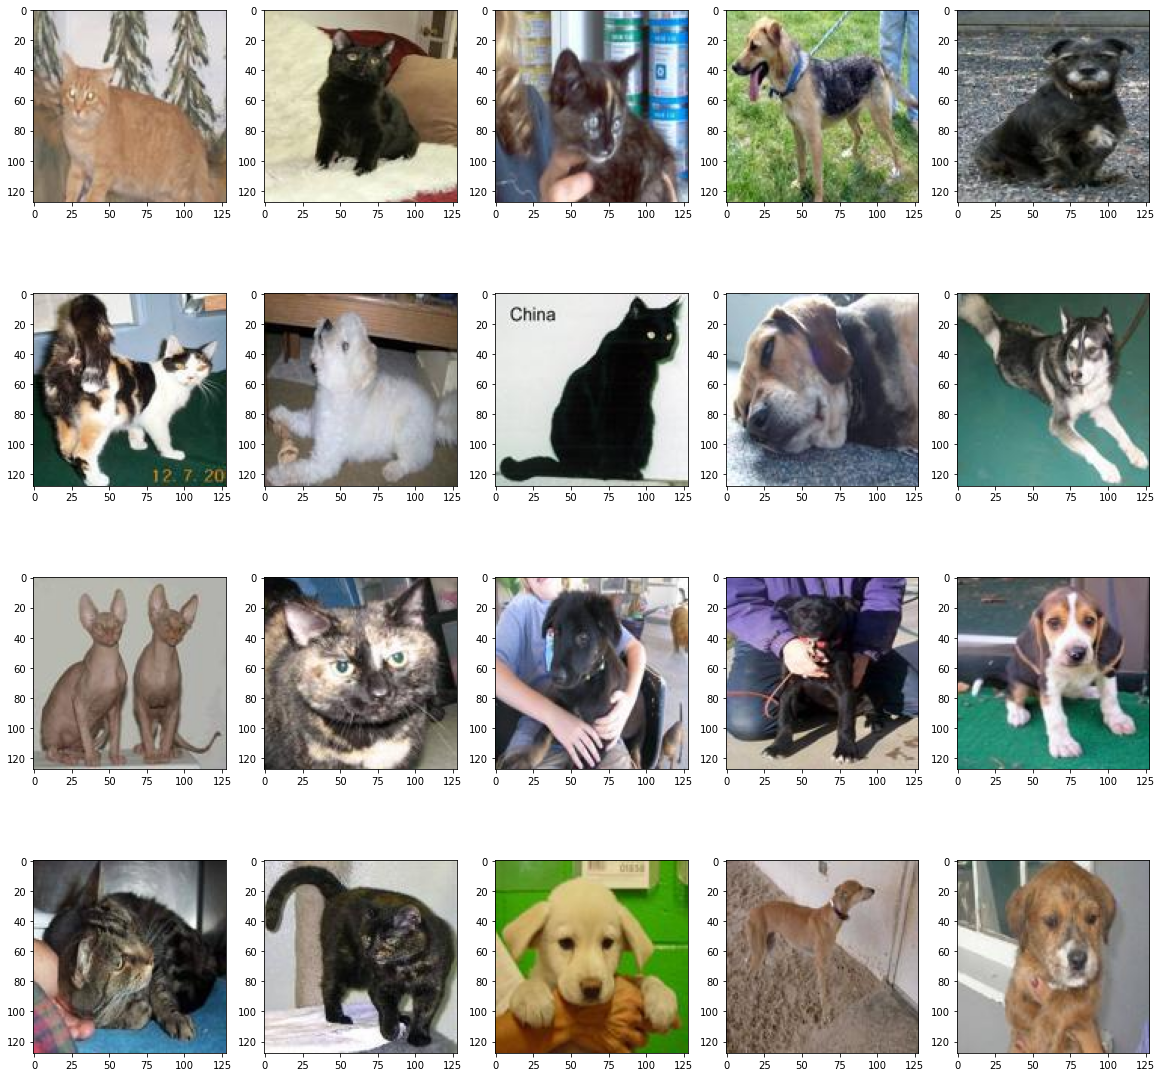

In [10]:
train_data = dataset["train_x"]
train_data_label = dataset["train_y"][0]
show_first_20(train_data,train_data_label)

IMG 1 is labelled 1
IMG 2 is labelled 1
IMG 3 is labelled 0
IMG 4 is labelled 1
IMG 5 is labelled 0
IMG 6 is labelled 1
IMG 7 is labelled 1
IMG 8 is labelled 1
IMG 9 is labelled 0
IMG 10 is labelled 1
IMG 11 is labelled 0
IMG 12 is labelled 1
IMG 13 is labelled 0
IMG 14 is labelled 1
IMG 15 is labelled 1
IMG 16 is labelled 1
IMG 17 is labelled 1
IMG 18 is labelled 0
IMG 19 is labelled 1
IMG 20 is labelled 1


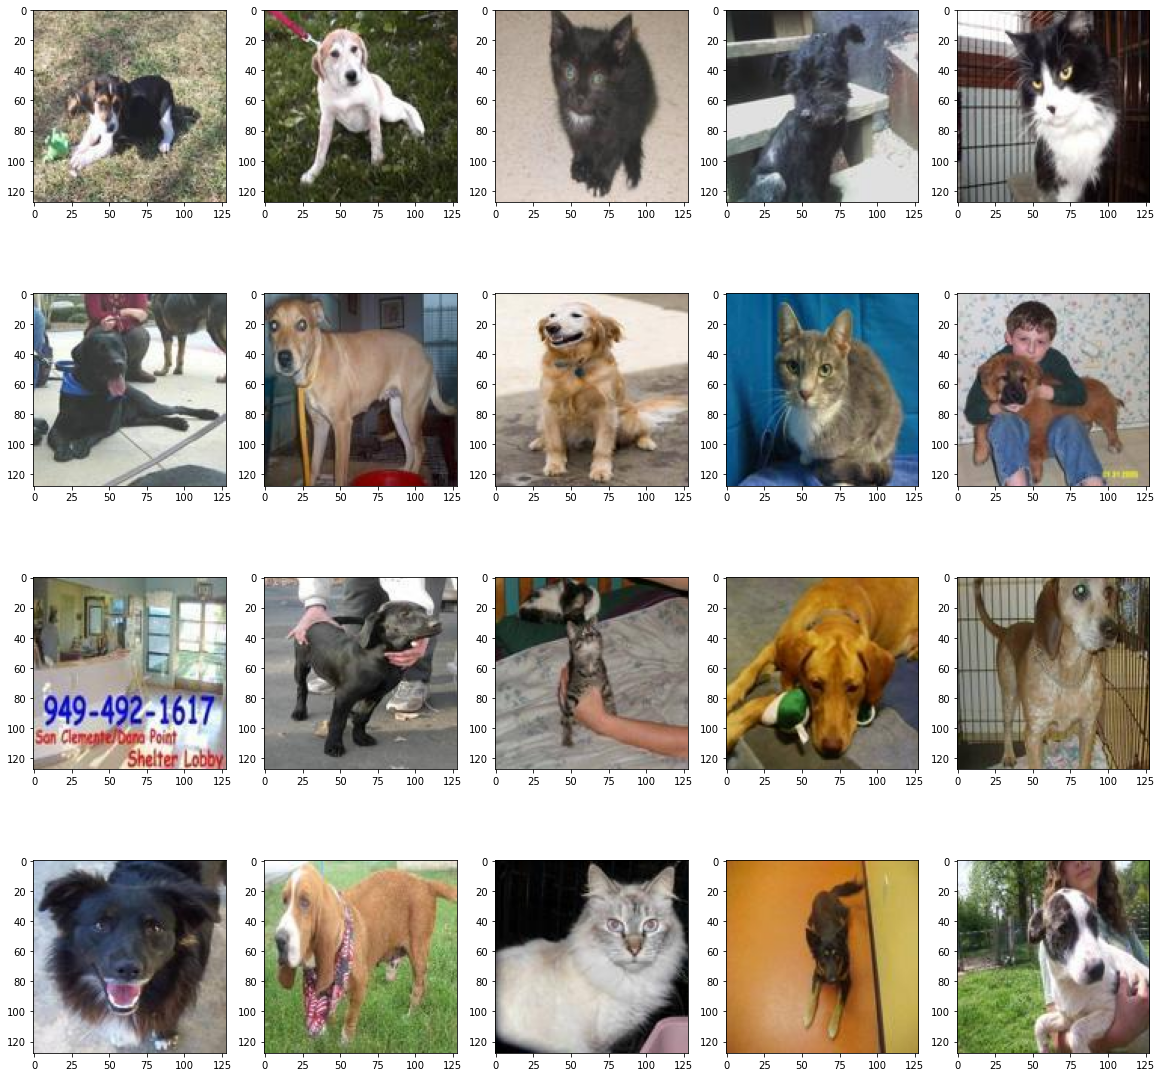

In [11]:
dev_data = dataset["dev_x"]
dev_data_label = dataset["dev_y"][0]
show_first_20(dev_data,dev_data_label)

IMG 1 is labelled 1
IMG 2 is labelled 1
IMG 3 is labelled 0
IMG 4 is labelled 1
IMG 5 is labelled 0
IMG 6 is labelled 1
IMG 7 is labelled 1
IMG 8 is labelled 1
IMG 9 is labelled 0
IMG 10 is labelled 1
IMG 11 is labelled 0
IMG 12 is labelled 1
IMG 13 is labelled 0
IMG 14 is labelled 1
IMG 15 is labelled 1
IMG 16 is labelled 1
IMG 17 is labelled 1
IMG 18 is labelled 0
IMG 19 is labelled 1
IMG 20 is labelled 1


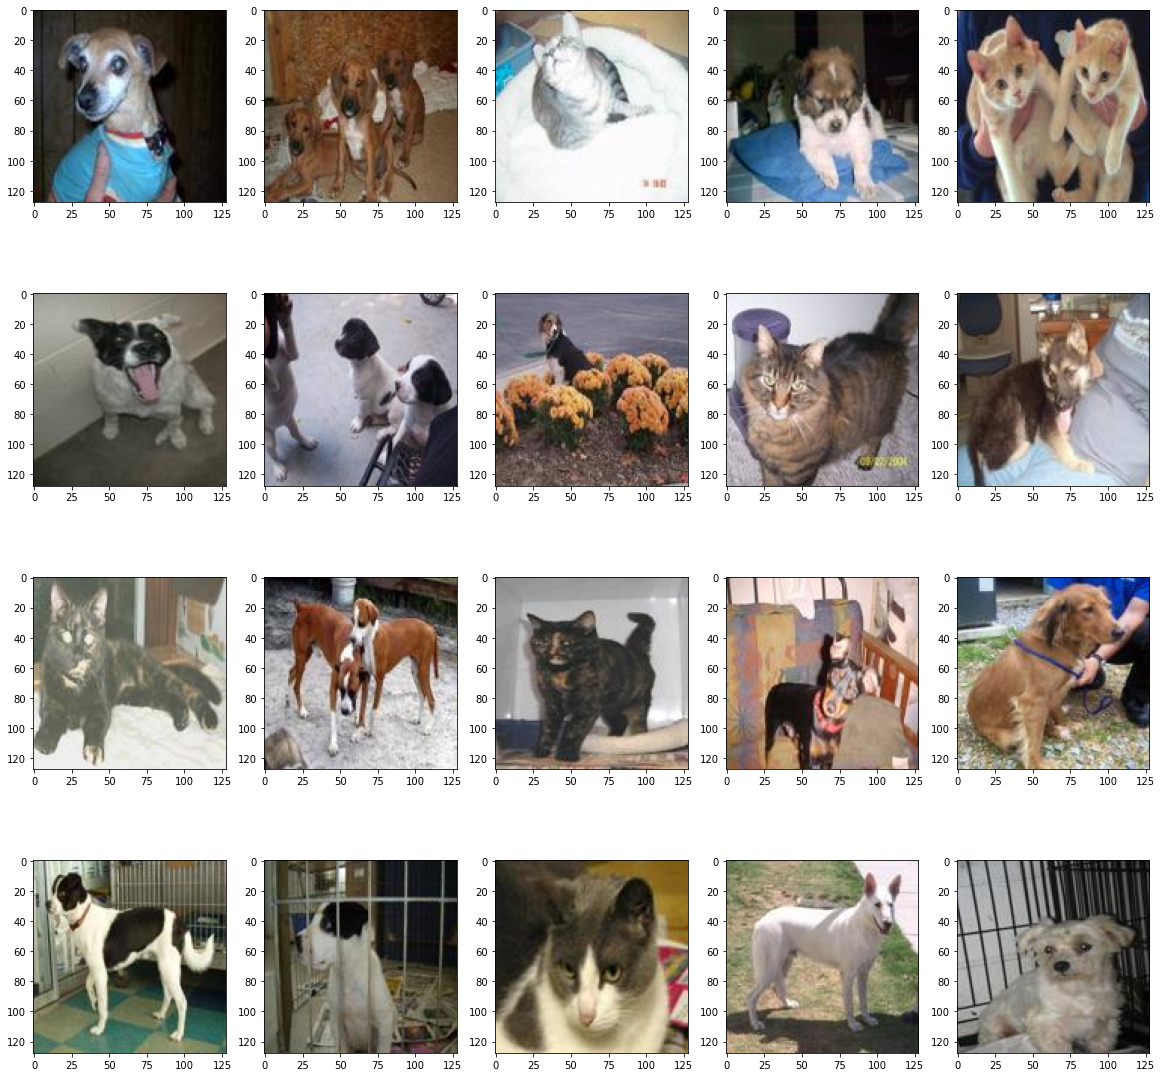

In [12]:
test_data = dataset["test_x"]
test_20_data_label = dataset["test_y"][0]
show_first_20(test_data,test_20_data_label)

## Generate H5 Data

In [13]:
def generate_h5_data(numpy_dataset, subpath, y0_label, y1_label):

    assert(type(y0_label) is str)
    assert(type(y1_label) is str)
    train_filepath =  subpath + f'train_{y0_label}V{y1_label}.h5'
    dev_filepath =  subpath + f'dev_{y0_label}V{y1_label}.h5'
    test_filepath = subpath + f'test_{y0_label}V{y1_label}.h5'
    
    h5train = h5py.File(train_filepath, 'w')
    h5train.create_dataset('train_set_x',data=numpy_dataset["train_x"])
    h5train['train_set_y'] = numpy_dataset["train_y"]
    h5train['train_list_classes'] = numpy_dataset["train_list_classes"]
    
    """DEBUG
    print(h5train['train_set_x'])
    print(h5train['train_set_y'])
    print(h5train['train_list_classes'])
    print(numpy_dataset["train_list_classes"])
    """
    h5train.close()
    
    h5dev = h5py.File(dev_filepath, 'w')
    h5dev.create_dataset('dev_set_x',data=numpy_dataset["dev_x"])
    h5dev['dev_set_y'] = numpy_dataset["dev_y"]
    h5dev['dev_list_classes'] = numpy_dataset["dev_list_classes"]
    
    """DEBUG
    print(h5train['dev_set_x'])
    print(h5dev['dev_set_y'])
    print(h5dev['dev_list_classes'])
    print(numpy_dataset["dev_list_classes"])
    """
    h5dev.close()
    
    h5test = h5py.File(test_filepath, 'w')
    h5test.create_dataset('test_set_x',data=numpy_dataset["test_x"])
    h5test['test_set_y'] = numpy_dataset["test_y"]
    h5test['test_list_classes'] = numpy_dataset["test_list_classes"]
    
    """DEBUG
    print(h5test['test_set_x'])
    print(h5test['test_set_y'])
    print(h5test['test_list_classes'])
    print(numpy_dataset["test_list_classes"])
    """
    h5test.close()

In [14]:
generate_h5_data(dataset,SUB_PATH,Y0,Y1)

## Review H5 Data

In [15]:
def review_h5_data(h5filepath,offset=0):
    h5file = h5py.File(h5filepath, "r")
    try:
        list_classes_fieldname, x_fieldname, y_fieldname = h5file.keys()
        print("The keys are: ", h5file.keys())
        set_x_orig = np.array(h5file[x_fieldname][:]) # your train/dev/test set features
        set_y_orig = np.array(h5file[y_fieldname][:]) # your train/dev/test set labels
        list_classes_orig = np.array(h5file[list_classes_fieldname][:]) # your train/dev/test set list classes
        print("The shape of x_field",set_x_orig.shape)
        print("The shape of y_field",set_y_orig.shape)
        print("The shape of list_classes_field",list_classes_orig.shape)
        show_first_20(set_x_orig,set_y_orig[0],offset)
    finally:
        h5file.close()

The keys are:  <KeysViewHDF5 ['train_list_classes', 'train_set_x', 'train_set_y']>
The shape of x_field (8000, 128, 128, 3)
The shape of y_field (1, 8000)
The shape of list_classes_field (1, 8000)
IMG 1 is labelled 0
IMG 2 is labelled 0
IMG 3 is labelled 0
IMG 4 is labelled 1
IMG 5 is labelled 1
IMG 6 is labelled 0
IMG 7 is labelled 1
IMG 8 is labelled 0
IMG 9 is labelled 1
IMG 10 is labelled 1
IMG 11 is labelled 0
IMG 12 is labelled 0
IMG 13 is labelled 1
IMG 14 is labelled 1
IMG 15 is labelled 1
IMG 16 is labelled 0
IMG 17 is labelled 0
IMG 18 is labelled 1
IMG 19 is labelled 1
IMG 20 is labelled 1


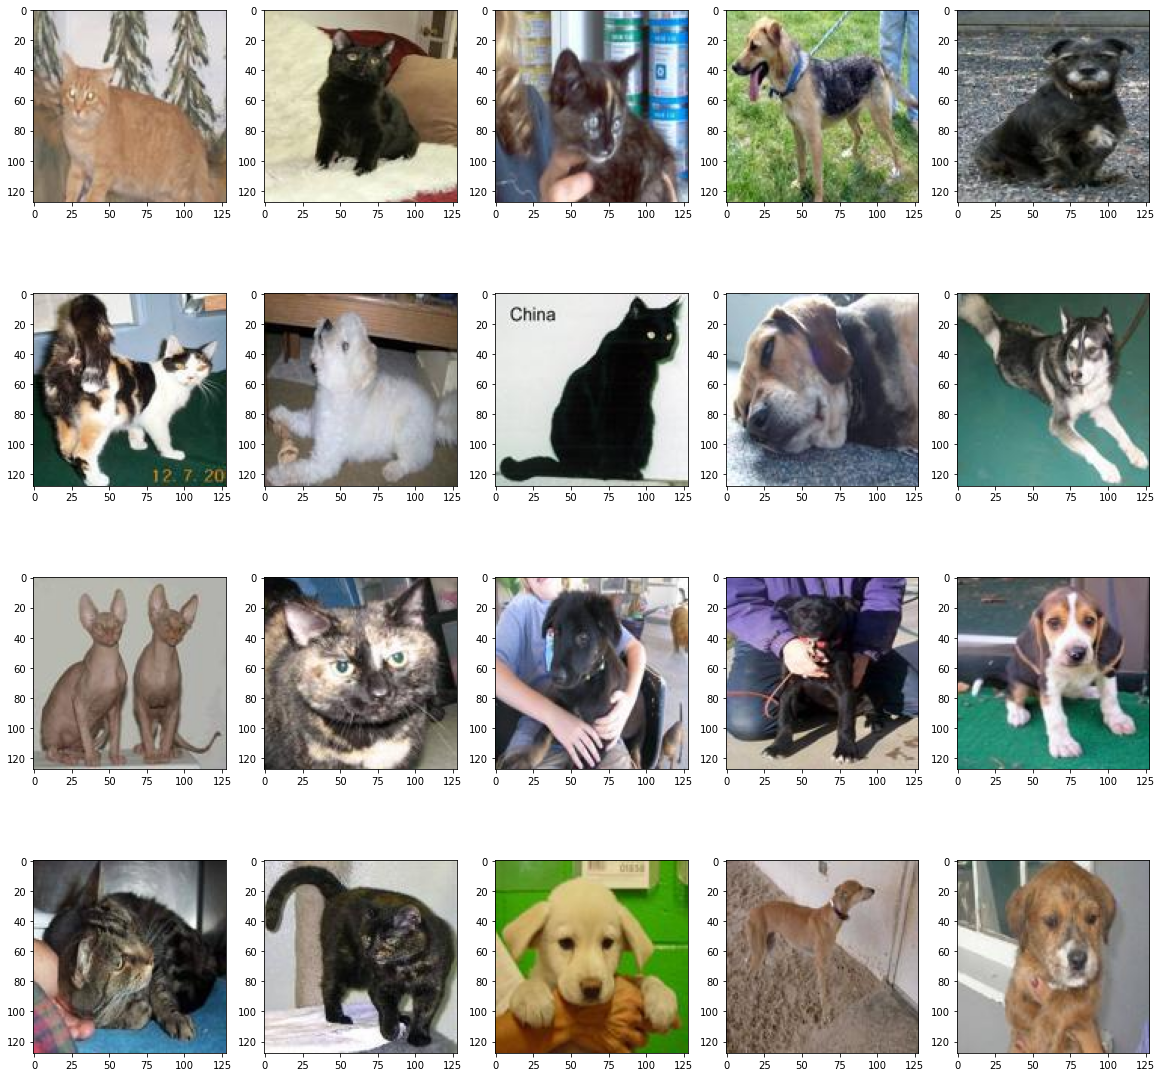

In [16]:
review_h5_data(SUB_PATH + 'train_' + Y0 +'V'+ Y1 + '.h5')

The keys are:  <KeysViewHDF5 ['dev_list_classes', 'dev_set_x', 'dev_set_y']>
The shape of x_field (1000, 128, 128, 3)
The shape of y_field (1, 1000)
The shape of list_classes_field (1, 1000)
IMG 1 is labelled 1
IMG 2 is labelled 1
IMG 3 is labelled 0
IMG 4 is labelled 1
IMG 5 is labelled 0
IMG 6 is labelled 1
IMG 7 is labelled 1
IMG 8 is labelled 1
IMG 9 is labelled 0
IMG 10 is labelled 1
IMG 11 is labelled 0
IMG 12 is labelled 1
IMG 13 is labelled 0
IMG 14 is labelled 1
IMG 15 is labelled 1
IMG 16 is labelled 1
IMG 17 is labelled 1
IMG 18 is labelled 0
IMG 19 is labelled 1
IMG 20 is labelled 1


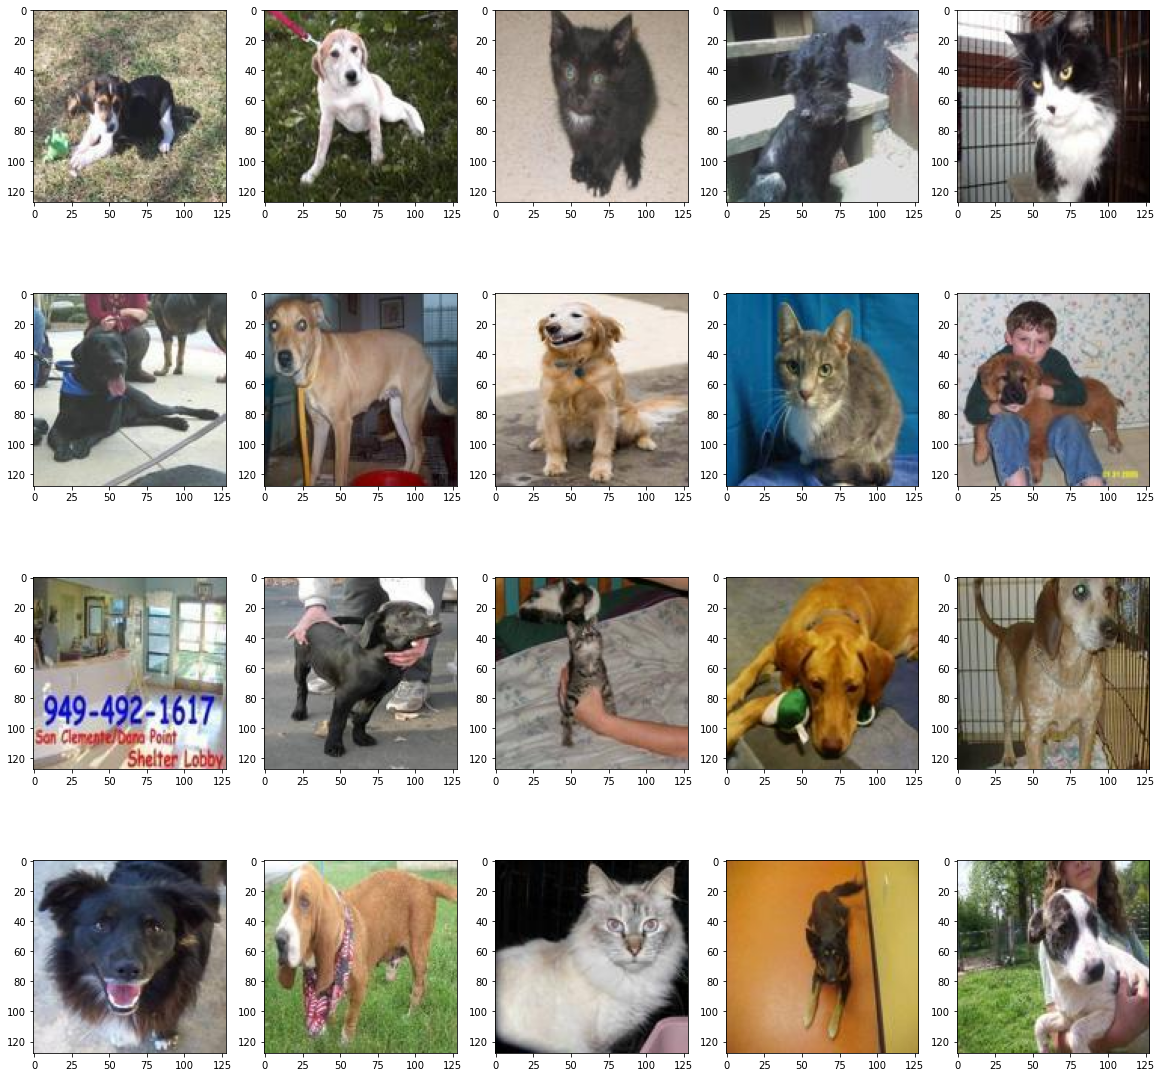

In [17]:
review_h5_data(SUB_PATH + 'dev_' + Y0 +'V'+ Y1 + '.h5')

The keys are:  <KeysViewHDF5 ['test_list_classes', 'test_set_x', 'test_set_y']>
The shape of x_field (1000, 128, 128, 3)
The shape of y_field (1, 1000)
The shape of list_classes_field (1, 1000)
IMG 1 is labelled 1
IMG 2 is labelled 1
IMG 3 is labelled 0
IMG 4 is labelled 1
IMG 5 is labelled 0
IMG 6 is labelled 1
IMG 7 is labelled 1
IMG 8 is labelled 1
IMG 9 is labelled 0
IMG 10 is labelled 1
IMG 11 is labelled 0
IMG 12 is labelled 1
IMG 13 is labelled 0
IMG 14 is labelled 1
IMG 15 is labelled 1
IMG 16 is labelled 1
IMG 17 is labelled 1
IMG 18 is labelled 0
IMG 19 is labelled 1
IMG 20 is labelled 1


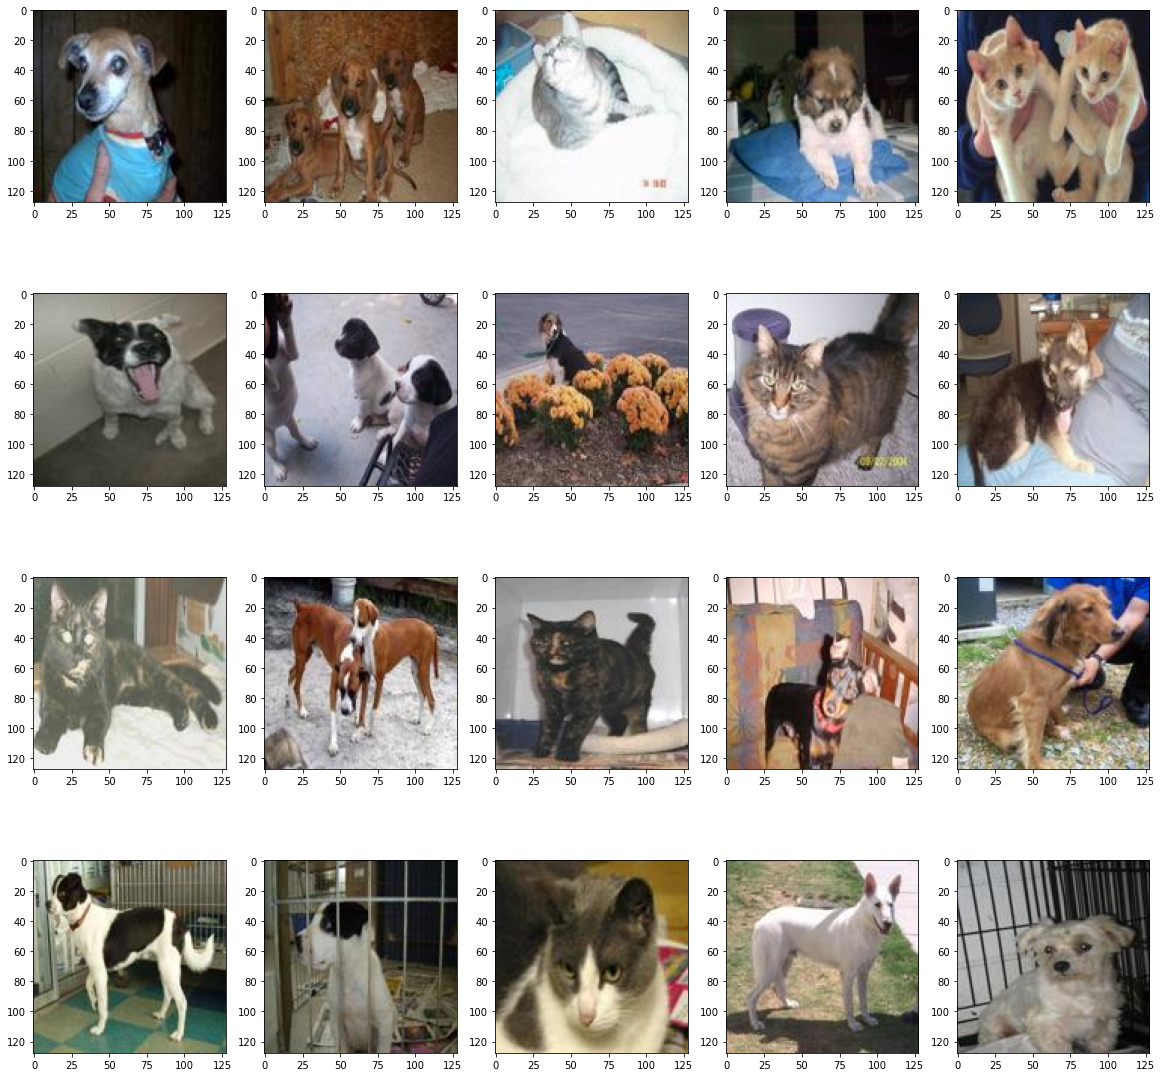

In [18]:
review_h5_data(SUB_PATH + 'test_' + Y0 +'V'+ Y1 + '.h5')